# Importance Sampling

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import beta
from scipy.stats import norm as mvn
from scipy.stats import expon
from matplotlib import pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 12, 7

In [2]:
t = np.linspace(-1,2,100)

In [3]:
def logsumexp(log_p,x=1,axis=0):
    a = np.max(log_p, axis = axis, keepdims=True)
    return np.log(np.sum(x*np.exp(log_p - a), axis=axis)) + np.squeeze(a,axis=axis) 

## Preliminaries

### Posterior Distribution of $\mu$

\begin{eqnarray}
\mu & \sim & \mathcal{N}(0,\sigma^2_{\mu}) \\
x_i & \sim & \mathcal{N}(\mu, \sigma^2)
\end{eqnarray}

In [4]:
sigma_mu = 30
sigma = 3

### Prior of $\mu$

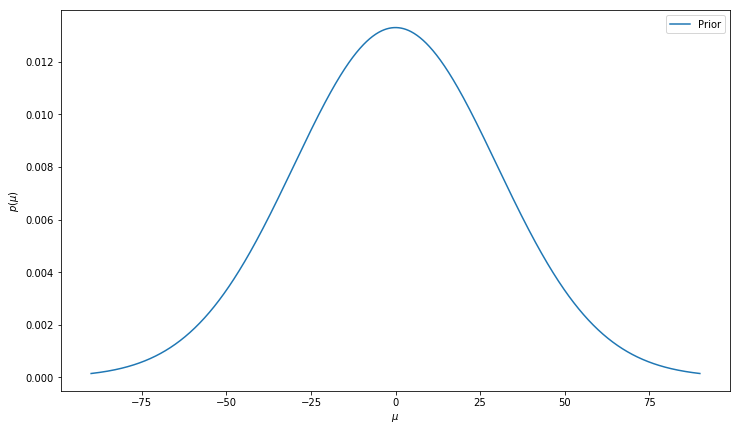

In [5]:
MU = np.linspace(-3*sigma_mu, 3*sigma_mu,1000)
plt.plot(MU,mvn.pdf(MU,0,sigma_mu),label="Prior")
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$")
plt.legend()
plt.show()

### Samples from $p(x \mid \mu)$

In [6]:
N = 1000
mu_true = mvn.rvs(0,sigma_mu,size=1)
x = mvn.rvs(mu_true,sigma,size=N)

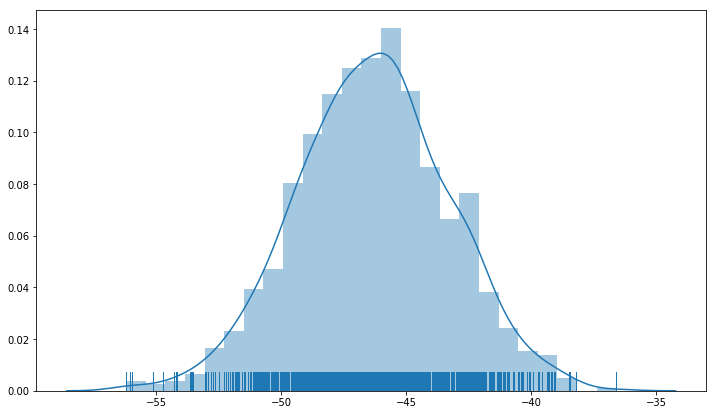

In [7]:
sns.distplot(x,rug=True,)
plt.show()

\begin{eqnarray}
p(\mu \mid x) & = & \frac{p(x,\mu)}{p(x)} \\
& \propto & p(x,\mu) \\
& = & p(x \mid \mu) p(\mu) \\
& = & p(\mu) \prod_i p(x_i \mid \mu) \\
& \propto & \exp{\left(- \frac{\mu^2}{2\sigma_{\mu}^2} \right)} \prod_i \exp{\left(- \frac{(\mu - x_i)^2}{2\sigma^2} \right)} \\
& = & \exp{\left(- \frac{\sum_i(\mu - x_i)^2}{2\sigma^2} - \frac{\mu^2}{2\sigma_{\mu}^2} \right)} \\
\log p(\mu \mid x) & =^+ & - \frac{\sum_i(\mu - x_i)^2}{2\sigma^2} - \frac{\mu^2}{2\sigma_{\mu}^2} \\
\end{eqnarray}

### Evolution of $p(\mu \mid x)$

In [8]:
log_posterior = lambda mu,x: - mu**2/(2*sigma_mu**2) - np.sum((x[None,:]-mu[:,None])**2,axis=1)/(2*sigma**2)

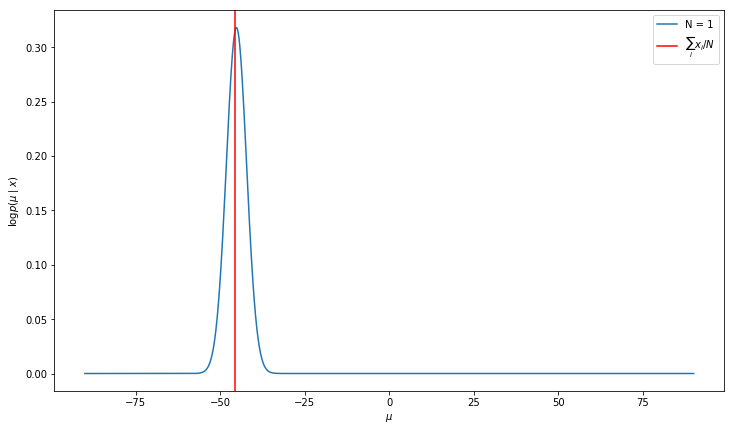

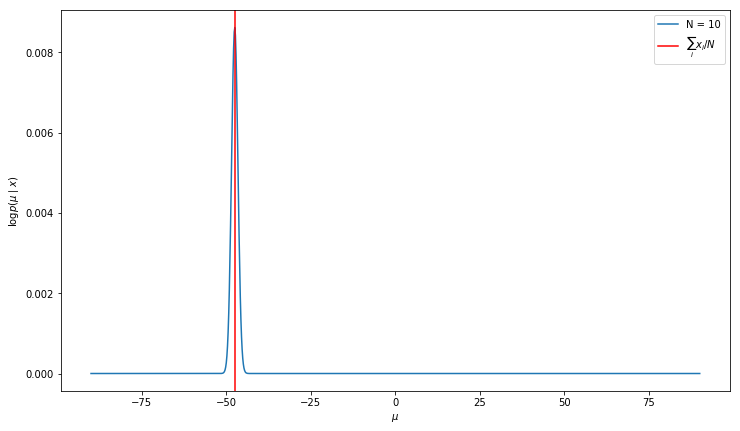

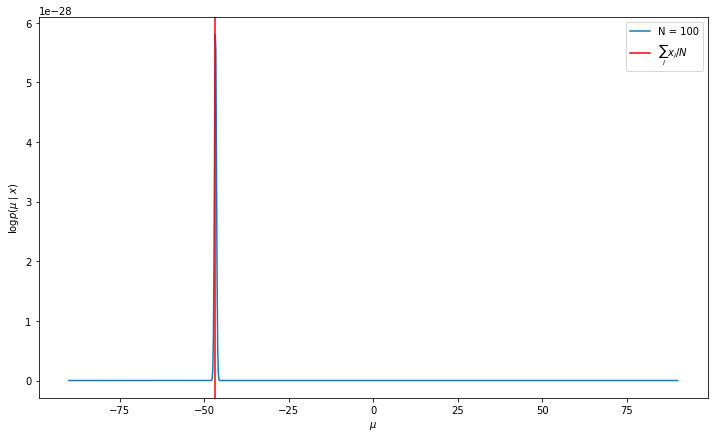

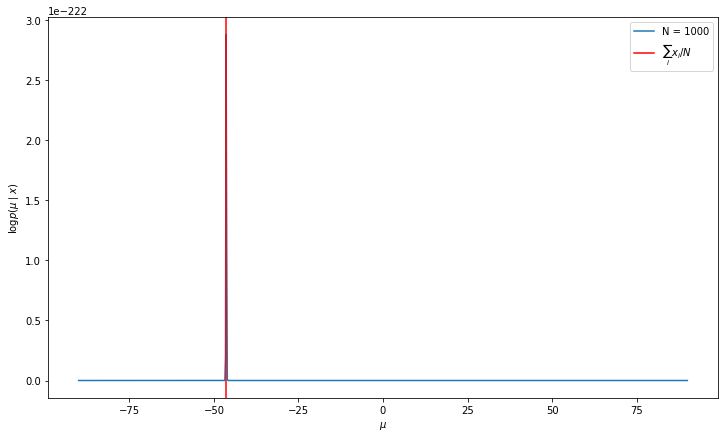

In [9]:
for n in [1,10,100,1000]:
    fig = plt.figure()
    plt.plot(MU,np.exp(log_posterior(MU,x[:n])),label="N = {}".format(n))
    plt.axvline(np.mean(x[:n]), label="$\sum_i x_i / N$",color="r")
    plt.xlabel("$\mu$")
    plt.ylabel("$\log p(\mu \mid x)$")
    plt.legend()
    plt.show()

## Importance Sampling under Unnormalized Distributions

Suppose $p(x)$ and $q(x)$ are probability distributions known up to some normalization constants, i.e.

\begin{eqnarray}
p(x) & = & \frac{1}{Z_f} f(x) \\
q(x) & = & \frac{1}{Z_g} g(x) \\
\end{eqnarray}

Then, the expectation of $\phi(x)$ under distribution $p(x)$ can be calculated by the following

\begin{eqnarray}
\left< \phi(x) \right>_{p(x)} & = & \int \phi(x) p(x) \, dx \\
& = & \frac{1}{Z_f} \int \phi(x) f(x) dx \\
& = & \frac{1}{Z_f} \int \phi(x) f(x) \frac{q(x)}{q(x)} \, dx \\
& = & \frac{Z_g}{Z_f} \int \phi(x) f(x) \frac{q(x)}{g(x)} \, dx \\
& = & \frac{Z_g}{Z_f} \int \phi(x) \frac{f(x)}{g(x)} q(x) \, dx \\
& = & \frac{Z_g}{Z_f} \left< \phi(x) \frac{f(x)}{g(x)} \right>_{q(x)} \\
& = & \frac{Z_g}{Z_f} \left< \phi(x) w(x) \right>_{q(x)} \\
\end{eqnarray}

where $w(x) = \dfrac{f(x)}{g(x)}$ and

\begin{eqnarray}
\left< w(x) \right>_{q(x)} & = & \int w(x) q(x) \, dx \\
& = & \int \frac{f(x)}{g(x)} q(x) \, dx \\
& = & \int \frac{f(x)}{Z_g} \, dx \\
& = & \frac{Z_f}{Z_g} \\
\end{eqnarray}

Let $x_1, x_2, \cdots x_N \sim q(x)$ be the samples from the unnormalized proposal distribution, thus

\begin{eqnarray}
\left< \phi(x) \right>_{p(x)} & = & \frac{Z_g}{Z_f} \left< \phi(x) w(x) \right>_{q(x)} \\
& = & \frac{\left< \phi(x) w(x) \right>_{q(x)}}{\left< w(x) \right>_{q(x)}} \\
& \approx & \frac{\frac{1}{N}\sum_i \phi(x_i) w(x_i)}{\frac{1}{N}\sum_i w(x_i)} \\
& = & \frac{\sum_i \phi(x_i) w(x_i)}{\sum_i w(x_i)} \\
\end{eqnarray}

## Simple Regression Model with Beta Priors

\begin{eqnarray}
a & \sim & \text{Beta}(\alpha_0,\alpha_1) \\
b & \sim & \text{Beta}(\beta_0,\beta_1) \\
x_i & \sim & \mathcal{U}[0,1] \\
\epsilon_i & \sim & \mathcal{N}(0,\sigma^2) \\
y_i & = & ax_i + b + \epsilon_i \\
\end{eqnarray}

## Generating Synthetic Data

In [10]:
D = 20
alpha_0, alpha_1 = 5,2
beta_0, beta_1 = 3,10
sigma = 0.2

In [11]:
a = beta.rvs(alpha_0,alpha_1)
b = beta.rvs(beta_0,beta_1)
x = beta.rvs(1,1,size=D)
epsilon = mvn.rvs(0,sigma,size=D)

In [12]:
y = a*x + b + epsilon

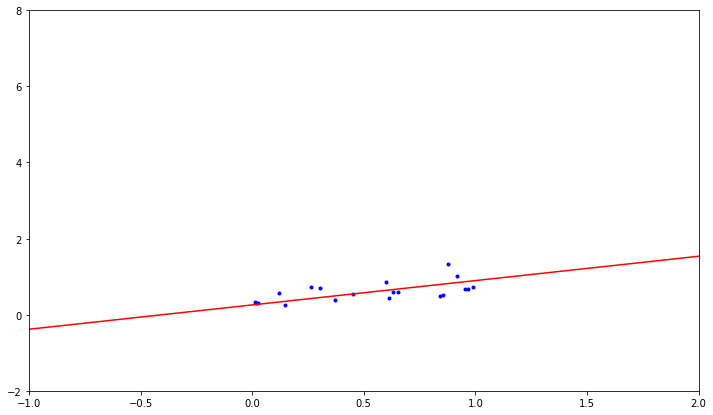

In [13]:
plt.scatter(x,y,marker='.',color='b')
plt.plot(t,a*t+b,color='r')
plt.xlim(-1,2)
plt.ylim(-2,8)
plt.show()

## Posterior Distribution of $a$ and $b$

\begin{eqnarray}
p(a,b \mid y,x) & \propto & p(y,a,b \mid x) \\
& = & p(y \mid x,a,b) p(a) p(b) \\
& = & p(a) p(b) \prod_i p(y_i \mid x_i,a,b) \\
& \propto & a^{\alpha_0 - 1} (1-a)^{\alpha_1 - 1} b^{\beta_0 - 1} (1-b)^{\beta_1 - 1} \prod_i \exp{\left(- \frac{(y_i - ax_i - b)^2}{2\sigma^2} \right)} \\
\log p(a,b \mid y,x) & =^+ & (\alpha_0 - 1)\log a + (\alpha_1 - 1) \log (1-a) \\
& + & (\beta_0 - 1)\log b + (\beta_1 - 1) \log (1-b) \\ 
& - & \sum_i \frac{(y_i - ax_i - b)^2}{2\sigma^2} \\
\end{eqnarray}

## Fitting a Line by Importance Sampling

### Proposal Distribution

We can use a uniform proposal (Beta distributions with parameters $\alpha_0 = \alpha_1 = 1$ and $\beta_0 = \beta_1 = 1$) for $a$ and $b$, i.e.

\begin{eqnarray}
q(a,b) & = & 1
\end{eqnarray}

In [14]:
N = 100
A = beta.rvs(1,1,size=N)
B = beta.rvs(1,1,size=N)

In [15]:
log_f = np.vectorize(
    lambda a,b: (alpha_0-1)*np.log(a) + (alpha_1-1)*np.log(1-a) + (beta_0-1)*np.log(b) + (beta_1-1)*np.log(1-b) 
    - np.sum((y-a*x-b)**2)/(2*sigma**2) 
)
log_q = lambda a,b: (1-1)*np.log(a) + (1-1)*np.log(1-a) + (1-1)*np.log(b) + (1-1)*np.log(1-b)
log_w = lambda a,b: log_f(a,b) - log_q(a,b)

In [16]:
Z_hat = np.exp(logsumexp(log_w(A,B)))
a_hat = np.exp(logsumexp(log_w(A,B),A))/Z_hat
b_hat = np.exp(logsumexp(log_w(A,B),B))/Z_hat

### Results

#### Proposed Lines

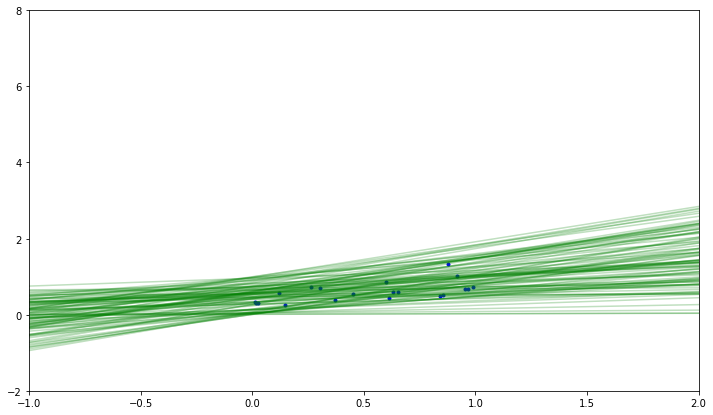

In [17]:
plt.scatter(x,y,marker='.',color='b')
for a,b in zip(A,B):
    plt.plot(t,a*t+b,color='g',alpha=0.25)
plt.xlim(-1,2)
plt.ylim(-2,8)
plt.show()

#### Importance Weights of the Lines

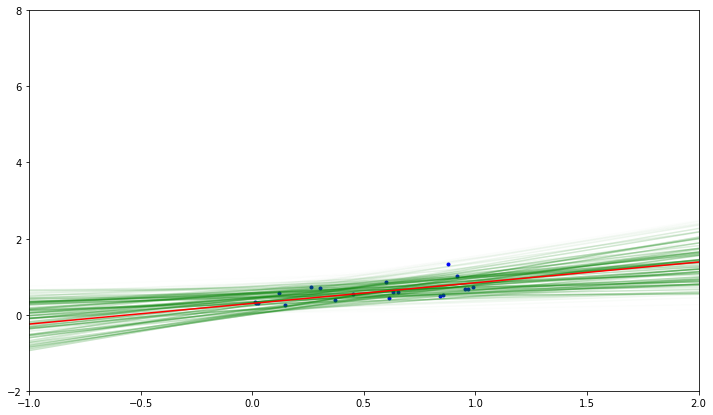

In [18]:
plt.scatter(x,y,marker='.',color='b')
for a,b in zip(A,B):
    plt.plot(t,a*t+b,color='g',alpha=np.exp(0.05*log_w(a,b)))
plt.plot(t,a_hat*t+b_hat,color='r',alpha=1)
plt.xlim(-1,2)
plt.ylim(-2,8)
plt.show()

## Regression Model with Exponential Noise

\begin{eqnarray}
a & \sim & \text{Beta}(\alpha_0,\alpha_1) \\
b & \sim & \text{Beta}(\beta_0,\beta_1) \\
\lambda & \sim & \text{Exp}(\gamma) \\
x_i & \sim & \mathcal{U}[0,1] \\
\epsilon_i & \sim & \text{Exp}(\lambda) \\
y_i & = & ax_i + b + \epsilon_i \\
\end{eqnarray}

## Generating Synthetic Data

In [19]:
D = 20
alpha_0, alpha_1 = 5,2
beta_0, beta_1 = 3,10
gamma = 0.0001

In [20]:
a = beta.rvs(alpha_0,alpha_1)
b = beta.rvs(beta_0,beta_1)
x = beta.rvs(1,1,size=D)
lam = expon.rvs(gamma)
epsilon = expon.rvs(lam,size=D)

In [21]:
y = a*x + b + epsilon

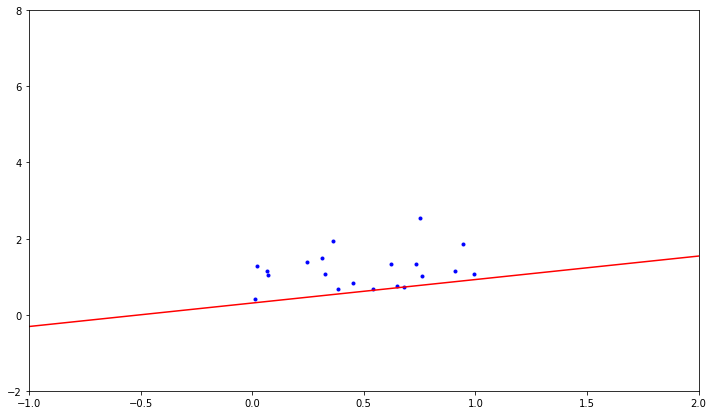

In [22]:
plt.scatter(x,y,marker='.',color='b')
plt.plot(t,a*t+b,color='r')
plt.xlim(-1,2)
plt.ylim(-2,8)
plt.show()

## Posterior Distribution of $a$, $b$ and $\lambda$

\begin{eqnarray}
p(a,b,\lambda \mid y,x) & \propto & p(y,a,b,\lambda \mid x) \\
& = & p(y \mid x,a,b,\lambda) \, p(a) \, p(b) \, p(\lambda) \\
& = & p(a) \, p(b) \, p(\lambda) \, \prod_i p(y_i \mid x_i,a,b,\lambda) \\
& \propto & a^{\alpha_0 - 1} (1-a)^{\alpha_1 - 1} b^{\beta_0 - 1} (1-b)^{\beta_1 - 1} e^{-\gamma \lambda}
\prod_i \lambda e^{- \lambda (y_i - ax_i - b)} \\
\log p(a,b, \lambda \mid y,x) & =^+ & (\alpha_0 - 1)\log a + (\alpha_1 - 1) \log (1-a) \\
& + & (\beta_0 - 1)\log b + (\beta_1 - 1) \log (1-b) \\
& - & \gamma\lambda +N \log{\lambda} - \sum_i \lambda \left( y_i - ax_i - b \right) \\
\end{eqnarray}

## Fitting a Line by Importance Sampling

### Proposal Distribution

We can use the prior distribution of $\lambda$ as proposal and uniform proposals for $a$ and $b$,

\begin{eqnarray}
q(a,b,\lambda) & \propto & e^{-\gamma \lambda}
\end{eqnarray}

In [23]:
N = 100
A = beta.rvs(1,1,size=N)
B = beta.rvs(1,1,size=N)
LAM = expon.rvs(gamma,size=N)

In [24]:
def log_likelihood(a,b,lam):
    if (y - a*x - b < 0).any():
        return -np.inf
    else:
        return y.size*np.log(lam) - lam*np.sum(y - a*x - b) - gamma*lam \
               + (alpha_0-1)*np.log(a) + (alpha_1-1)* np.log(1-a) + (beta_0-1)*np.log(b) + (beta_1-1)*np.log(1-b)

In [25]:
log_f = np.vectorize(log_likelihood)
log_q = lambda a,b,lam: (1-1)*np.log(a) + (1-1)*np.log(1-a) + (1-1)*np.log(b) + (1-1)*np.log(1-b) - gamma*lam
log_w = lambda a,b,lam: log_f(a,b,lam) - log_q(a,b,lam)

In [26]:
Z_hat = np.exp(logsumexp(log_w(A,B,LAM)))
a_hat = np.exp(logsumexp(log_w(A,B,LAM),A))/Z_hat
b_hat = np.exp(logsumexp(log_w(A,B,LAM),B))/Z_hat

### Results

#### Proposed Lines

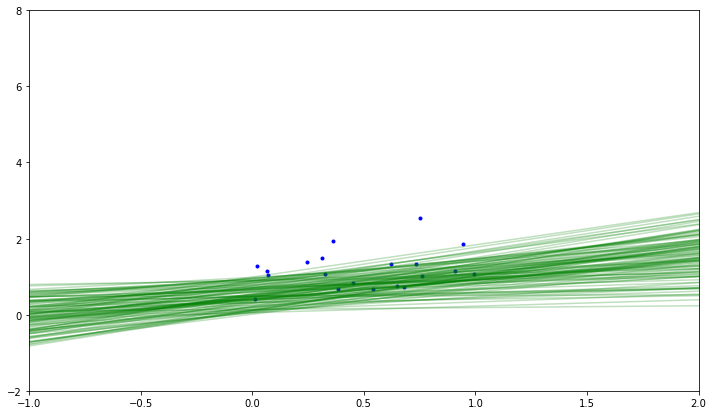

In [27]:
plt.scatter(x,y,marker='.',color='b')
for a,b,lam in zip(A,B,LAM):
    plt.plot(t,a*t+b,color='g',alpha=0.25)
plt.xlim(-1,2)
plt.ylim(-2,8)
plt.show()

#### Importance Weights of the Lines

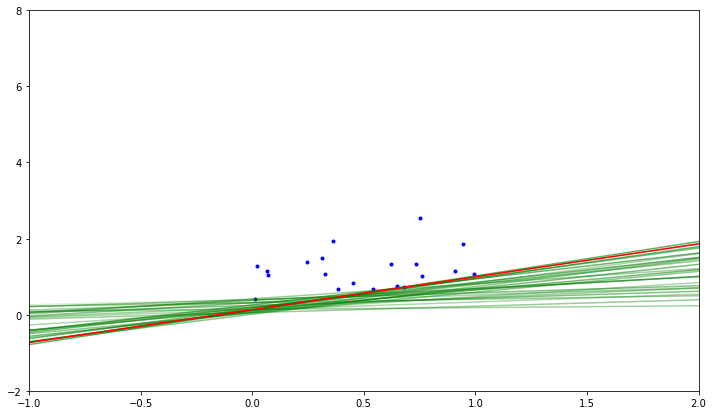

In [28]:
plt.scatter(x,y,marker='.',color='b')
for a,b,lam in zip(A,B,LAM):
    plt.plot(t,a*t+b,color='g',alpha=np.exp(0.025*log_w(a,b,lam)))
plt.plot(t,a_hat*t+b_hat,color='r',alpha=1)
plt.xlim(-1,2)
plt.ylim(-2,8)
plt.show()